
# BBC News Classification
<p>CSCA-5632 Unsupervised Algorithms in Machine Learning</p>
<p>University of Colorado Boulder</p>
<p>@author alme9155@colorado.edu</p>
<hr/>

<h2>I. Project Overview:</h2>
<h3>I.i.Objectives</h3>
<h3>This class project categorizes news articles using matrix factorization to predict the categories. </h3> 

This notebook includes the following:
* Brief EDA procedures
* Matrix factorization model building and training
* Model predictions and results
* Prediction results comparison with Supervised Learning

<h3>I.ii. Project Description</h3>
This project will use a public dataset from the BBC comprised of 2225 articles, each labeled under one of the five categories: business, entertainment, politics, sport, or tech. It is a balanced dataset that. Each category has about 400~500 articles, which ensures meaningful classification.

<ul>
<li>Data source: <a url="https://kaggle.com/competitions/learn-ai-bbc">https://kaggle.com/competition/learn-ai-bbc</a></li>
<li>Bijoy Bose. BBC News Classification</li>
<li>year: 2019</li>
</ul>

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input/learn-ai-bbc'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


<h2>II. Exploratory Data Analysis</h2>

<h3>II.i.Loading the data from Kaggle competition</h3>
This notebook require internet connection to download dataset from the kaggle competition.

<h3>II.ii.Exploring and understanding the data</h3>
Explore dataset structure and visualize frequency of categories in the BBC dataset.

In [2]:
# EDA process
# 1. load the dataset
# 2. inspect the data

## loading the data
train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
print(f"Data loaded successfully.")

print(f"\nTraining Data Info:")
print("--------------------------")
print(train.info())
print(f"\nTesting Data Info:")
print("--------------------------")    
print(test.info())

print(f"\nFirst five rows of training data:")
print("--------------------------")    
print(train.head())
print(f"\nFirst five rows of testing data:")
print("--------------------------")    
print(test.head())

print(f"\nMissing values in Training Set:")
print("--------------------------")    
print(train.isnull().sum())
print(f"\nMissing Values in Test Set:")
print("--------------------------")    
print(test.isnull().sum())

print("\nArticle Categories")
print("--------------------------")    
unique_categories = train['Category'].unique()
print(f"Unique Article categories:{unique_categories}")
print(f"Number of categories:{len(unique_categories)}")

Data loaded successfully.

Training Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None

Testing Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None

First five rows of training data:
--------------------------
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  busin

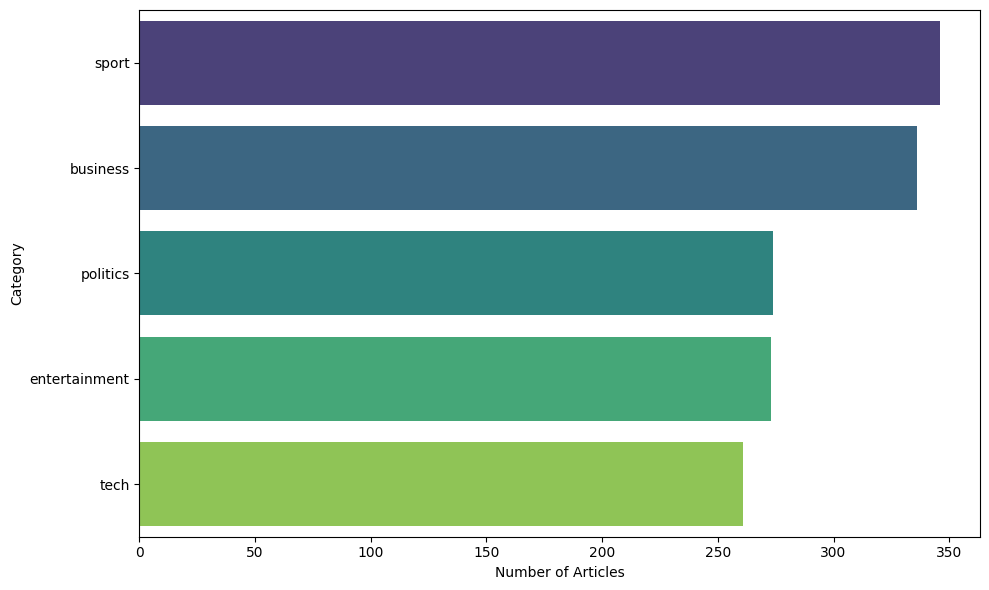

In [3]:
# here is a bar chart of the count of text category
category_count = train["Category"].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(y=category_count.index, x=category_count.values, palette='viridis')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


<h2>III. Cleaning and Preparing the data</h2>
Use the Term Frequency-Inverse Document Frequency Vectorizer(TF-IDF) Vectorizer to convert raw text into features tokens.

Built-in function of vectorizer will clean the data with the following steps:
* 1. lower text to lower characters </i>(lowercase=True)</i>
* 2. remove any token with 2 characters or less <i>(r'\b[a-zA-Z]{3,}\b')</i>
* 3. remove all punctuation from string library
* 4. remove all non-meaningful stop words, such as "is", "the", "and", etc.

<b>Expected output:</b>
The Vectorizer will convert raw text into features tokens.
* 1. tokenize the text into words
* 2. count words frequency per documents
* 3. compute TF-IDF scores
* 4. create sparse matrix row=documents, columns=vocabulary word
<pre><code>
For example, <b><i>"mens are from mars, women from Venus"</i></b><br/>
</code>
<code>
<i>(after cleaning and tokenize)</i>
feature names: ["men", "from", "mars", "women", "venus"]<br/>
scores_per_article:[ <br/>
    [0.125, 0.25, 0.125, 0.125, 0.125]<br/>
    ...<br/>
]
</code></pre>

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# TF-IDF vectorizer will clean the data:
#
# 1. lower text to lower characters
# 2. tokenize text into words using regex
# 3. remove any token with 2 characters or less. "r'\b[a-zA-Z]{3,}\b'"
# 4. remove all punctuation from string library
# 5. remove all non-meaningful english stop words, such as "is", "the", "and", etc.

# TF-IDF vectorizer with built-in preprocessing
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=5000,
    token_pattern=r'\b[a-zA-Z]{3,}\b'  
)

x_train_tfidf = vectorizer.fit_transform(train['Text'])
x_test_tfidf = vectorizer.transform(test['Text'])

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train['Category'])
print(f"Data are cleaned and pre-processing complete.")

Data are cleaned and pre-processing complete.


<h2>IV. Apply Matrix factorization and build and train model for prediction</h2>
After tokenization, the new token vector matrix is sparse with 5000 features x 1490 articles.
We will apply Truncated SVD (singular value decomposition) to reduce dimensionality.

Steps:
* 1. Split the TF-IDF train dataset into 80%/20% part.
* 2. Run matrix factorization by setting number of components equals to number of categories (NMF)
* 3. Apply NMF for dimensionality reduction
* 4. Cluster document with the best SVD component (argmax)
* 5. Map each NMF component to a class label
* 6. Predict on validate set using com
* 7. Prepare CSV for submission

Train Accuracy (NMF, n_components=5): 0.892
Test Accuracy (NMF, n_components=5): 0.916

Classification Report:
               precision    recall  f1-score   support

     business       0.91      0.96      0.94        75
entertainment       1.00      0.70      0.82        46
     politics       0.96      0.93      0.95        56
        sport       0.93      1.00      0.96        63
         tech       0.83      0.93      0.88        58

     accuracy                           0.92       298
    macro avg       0.93      0.90      0.91       298
 weighted avg       0.92      0.92      0.91       298



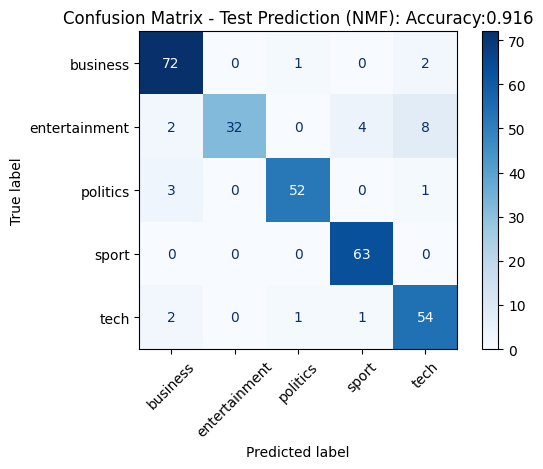

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# split the train dataset to 80%/20% 
x_train, x_validate, y_train_split, y_validate = \
    train_test_split(x_train_tfidf, y_train, test_size=0.2, random_state=42)


# Match latent dimension of NMF with unique number of categories
unique_categories = len(train['Category'].unique())

nmf = NMF(n_components=unique_categories, random_state=42)
x_train_nmf = nmf.fit_transform(x_train)
x_validate_nmf = nmf.transform(x_validate)
x_test_nmf = nmf.transform(x_test_tfidf)

# Find the most frequent category for each NMF feature in training data as category prediction
feature_prediction = np.argmax(x_train_nmf, axis=1)  

used = set()
feature_to_category = {}
# Get the true label for articles 
for component in range(unique_categories):
    if np.isin(component, feature_prediction):
        label = np.bincount(y_train_split[(feature_prediction == component)]).argmax()
        feature_to_category[component] = label
        used.add(label)
    else:
        for i in range(len(le.classes_)):
            if i not in used:
                feature_to_category[component] = i
                used.add(i)
                break
        else:
            feature_to_category[component] = 0 


# Prediction on training
y_pred_train_components = np.argmax(x_train_nmf, axis=1)
y_pred_nmf_train = np.array([feature_to_category[comp] for comp in y_pred_train_components])
score_nmf_train = accuracy_score(y_train_split, y_pred_nmf_train)

# Prediction on testing
y_pred_validate_components = np.argmax(x_validate_nmf, axis=1)
y_pred_nmf = np.array([feature_to_category[comp] for comp in y_pred_validate_components])
score_nmf = accuracy_score(y_validate, y_pred_nmf)

print(f"Train Accuracy (NMF, n_components={unique_categories}): {score_nmf_train:.3f}")
print(f"Test Accuracy (NMF, n_components={unique_categories}): {score_nmf:.3f}")
print("\nClassification Report:")
print(classification_report(y_validate, y_pred_nmf, target_names=le.classes_))

# Confusion Matrix 
cm_nmf = confusion_matrix(y_validate, y_pred_nmf)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_nmf, display_labels=le.classes_)
disp_val.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix - Test Prediction (NMF): Accuracy:{score_nmf:.3f}")
plt.tight_layout()
plt.show()

<h2>V. Plot prediction vs Actual category counts</h2>

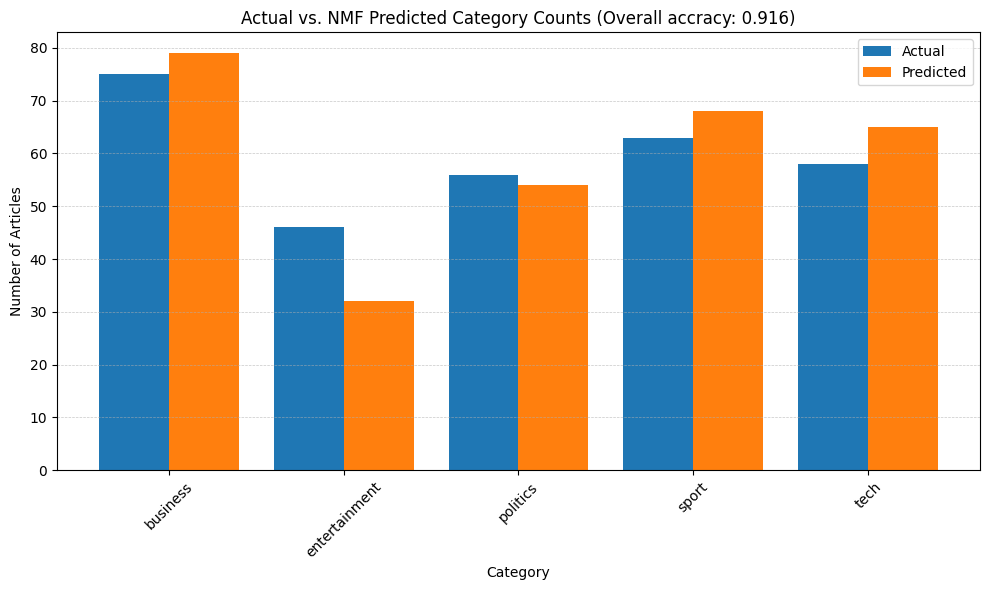

In [6]:
import matplotlib.pyplot as plt

actual_count = pd.Series(y_validate).value_counts().sort_index()
nmf_predicted_count = pd.Series(y_pred_nmf).value_counts().sort_index()

label_name = le.inverse_transform(sorted(actual_count.index))

x = range(len(label_name))
plt.figure(figsize=(10, 6))
plt.bar(x, actual_count, width=0.4, label='Actual', align='center')
plt.bar([i + 0.4 for i in x], nmf_predicted_count, width=0.4, label='Predicted', align='center')
plt.xticks([i + 0.2 for i in x], label_name, rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.title(f"Actual vs. NMF Predicted Category Counts (Overall accracy: {score_nmf:.3f})")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.legend()
plt.tight_layout()
plt.show()

<h2>VI. Compare result with supervised learning</h2>
Train and build SVM model, and compare the result of the supervised learning with the previous prediction.


Best SVM Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Validation Accuracy (SVM): 0.977


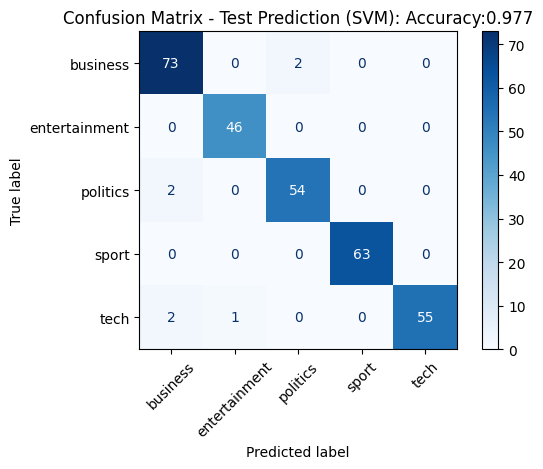

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'] 
}

svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(x_train, y_train_split)

print(f"Best SVM Params: {svm_grid.best_params_}")
y_pred_svm = svm_grid.predict(x_validate)
score_svd = accuracy_score(y_validate, y_pred_svm)
print(f"Validation Accuracy (SVM): {score_svd:.3f}")

# Confusion Matrix 
cm_svm = confusion_matrix(y_validate, y_pred_svm)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
disp_val.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix - Test Prediction (SVM): Accuracy:{score_svd:.3f}")
plt.tight_layout()
plt.show()

best_svm = svm_grid.best_estimator_
best_svm.fit(x_train_tfidf, y_train)
test_predictions_svm = best_svm.predict(x_test_tfidf)
test_predictions_svm_label = le.inverse_transform(test_predictions_svm)

submission_svm = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': test_predictions_svm_label
})
submission_svm.to_csv('svm_submission.csv', index=False)

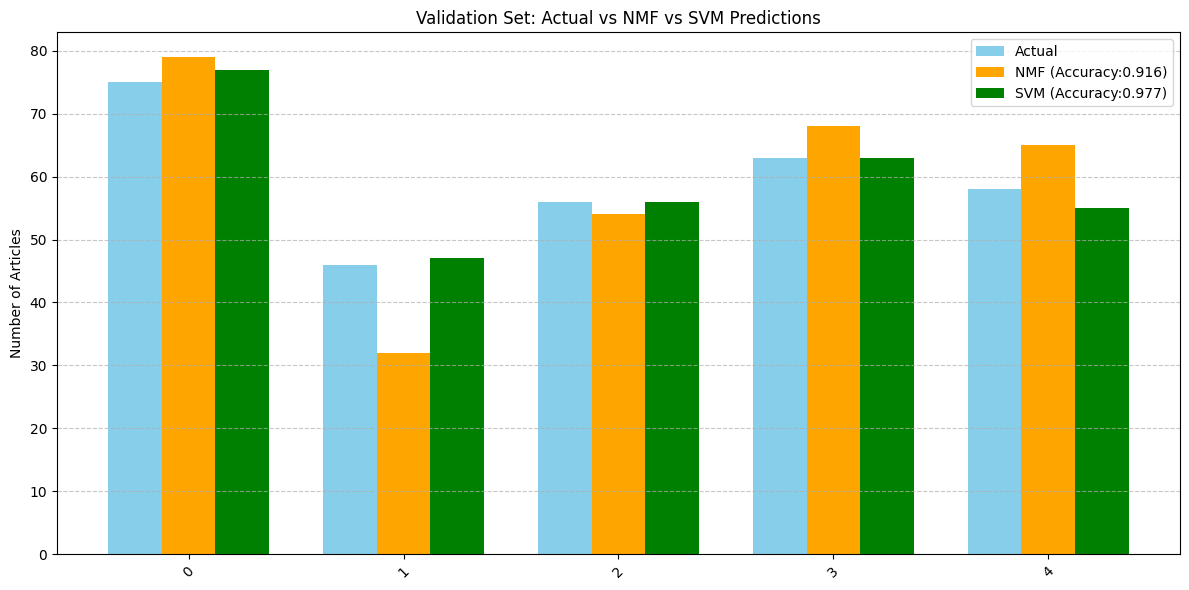

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

label_idx = sorted(set(y_validate)) 
label_name = le.inverse_transform(label_idx)

actual_count = pd.Series(y_validate).value_counts().sort_index()
nmf_count = pd.Series(y_pred_nmf).value_counts().sort_index()
svm_count = pd.Series(y_pred_svm).value_counts().sort_index()

actual_count = [actual_count.get(i, 0) for i in label_idx]
nmf_count = [nmf_count.get(i, 0) for i in label_idx]
svm_count = [svm_count.get(i, 0) for i in label_idx]

x = np.arange(len(label_idx))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 0.25, actual_count, 0.25, label='Actual', color='skyblue')
ax.bar(x, nmf_count, 0.25, label=f"NMF (Accuracy:{score_nmf:.3f})", color='orange')
ax.bar(x + 0.25, svm_count, 0.25, label=f"SVM (Accuracy:{score_svd:.3f})", color='green')

ax.set_xticks(x)
ax.set_xticklabels(label_idx, rotation=45)
ax.set_ylabel("Number of Articles")
ax.set_title("Validation Set: Actual vs NMF vs SVM Predictions")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:

# from sklearn.decomposition import TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, classification_report

# # split the train dataset to 80%/20% 
# x_train, x_validate, y_train_split, y_validate = \
#     train_test_split(x_train_tfidf, y_train, test_size=0.2, random_state=42)

# # hyper-parameter grid:
# n_component_option = [50, 100, 200] #SVD
# c_value_option = [0.1, 1.0, 10.0] #logistric regression (1/lambda)

# best_score_svd = 0
# best_model = None
# best_params = {}

# for n in n_component_option:
#     # Use TruncatedSVD to reduce dimension
#     svd = TruncatedSVD(n_components=n, random_state=42)
#     x_train_svd = svd.fit_transform(x_train)
#     x_validate_svd = svd.transform(x_validate)
#     x_test_svd = svd.transform(x_test_tfidf)

#     #train and test model
#     for c_option in c_value_option:
#         clf = LogisticRegression(max_iter=1000, C=c_option)
#         clf.fit(x_train_svd, y_train_split)

#         y_validate_pred = clf.predict(x_validate_svd)
#         acc = accuracy_score(y_validate, y_validate_pred)
#         print(f"SVD({n}) -> Logistic Regression(C={c_option}) -> Accuracy: {acc:.3f}")

#         # Track best model
#         if acc > best_score_svd:
#             best_score_svd = acc
#             best_model = clf
#             best_params = {
#                 'n_component': n,
#                 'c': c_option,
#                 'model': svd,
#                 'x_test_svd': x_test_svd 
#             }

# # Evaluate best model
# print(f"Best Parameters: n_components:{best_params['n_component']}, c: {best_params['c']}")
# print(f"Best Validation Accuracy: {best_score_svd:.3f}")
# y_pred_svd = best_model.predict(best_params['model'].transform(x_validate))

# # Predict on test set and create submission
# test_prediction = best_model.predict(best_params['x_test_svd'])
# test_prediction_label = le.inverse_transform(test_prediction)
# print(classification_report(y_validate, y_pred_svd, target_names=le.classes_))

# submission_svd_lg = pd.DataFrame({
#     'ArticleId': test['ArticleId'],
#     'Category': test_prediction_label
# })
# submission_svd_lg.to_csv('svd_submission.csv', index=False)


<h2>VII.Conclusion</h2>

In this notebook, I have submitted two predictions. One using unsupervised classification with Non-negative Matrix Factorization(NMF), and the other using supervised classification with Support Vector Machine (SVM), to predict topics of news articles in one of five categories: entertainment, sports, tech, politics, and business.

Both methods provided fairly high accuracy of 90-95% on both the provided data and the public test set. HBGB performed slightly higher than NMF. Further improvements could be made with additional hyperparameter tuning, ensembling, adjusting the pre-processing and vectorization approaches, and potentially including alternative machine learning approaches.
